# Step Identifier

## Why
Getting to know each step taken is key towards measuring its *quality and consequence* for a gait event during a walking session. As presented in [Fast.ai's Fastbook](https://nbviewer.org/github/fastai/fastbook/blob/master/01_intro.ipynb#Image-Recognizers-Can-Tackle-Non-Image-Tasks) literature, time series could be transformed into images that could be used to train a recognizer to identify and predict over, using capacity built for that domain.

## Brainstorm

* From a pre captured session, get an image based dataset where each sample represents a second of 3 axis waves stamped as an image. Something like the following.

![Figure 1](./per-second.png)

*  Group samples into categories (using techniques such as `from scipy.signal import find_peaks`) to get a big pictyure on how distribution works. Identifying  and differentiating steps per origin.

* [defer-for-later] Match against tri-axial device gathered data, merging the corresponding dat segment, into a single row. This will add features to each sample.

* To each origin (n, m or 1, 2), label it.

* Train a prediction model. Measure it 80/20.

* Compare models between simple (per second) and extended (half-second displaced `window`) datasets

In [1]:
# importing libraries
%matplotlib inline
import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv("../datasets/wit/wit-10hz.csv", sep='\t')
df_raw.columns = ["time", "acx", "acy", "acz","gyx", "gyy", "gyz", "roll", "pitch", "yaw"]
df_raw.drop(["roll", "pitch", "yaw"], axis=1, inplace=True)

df_raw['timedf'] = pd.to_datetime(df_raw['time'])
df_raw.info()
df_raw.drop('time', axis=1, inplace=True)

# Cheap tri-axial accelerometer normalization
df_raw['sac'] = np.sqrt(np.power(df_raw['acx'], 2) + np.power(df_raw['acy'], 2) + np.power(df_raw['acz'], 2))
# Cheap tri-axial gyroscope normalization
df_raw['sgy'] = np.sqrt(np.power(df_raw['gyx'], 2) + np.power(df_raw['gyy'], 2) + np.power(df_raw['gyz'], 2)) / 32768.0 * 2000

df_raw.columns = ['acx', 'acy', 'acz', 'gyx', 'gyy', 'gyz', 'time', 'sac', 'sgy']

df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64892 entries, 0 to 64891
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    64892 non-null  object        
 1   acx     64892 non-null  float64       
 2   acy     64892 non-null  float64       
 3   acz     64892 non-null  float64       
 4   gyx     64892 non-null  float64       
 5   gyy     64892 non-null  float64       
 6   gyz     64892 non-null  float64       
 7   timedf  64892 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 4.0+ MB


,acx,acy,acz,gyx,gyy,gyz,time,sac,sgy
0,0.094727,0.076172,0.029297,6.835938,6.896973,12.329102,2021-05-30 11:04:36.586,0.125034,0.957892
1,0.114746,0.064453,0.098633,5.432129,2.990723,13.488770,2021-05-30 11:04:36.670,0.164467,0.906119
2,0.091309,0.042969,0.109863,13.183594,0.732422,13.122559,2021-05-30 11:04:36.760,0.149176,1.136214
3,0.091309,0.054688,0.110840,6.347656,0.549316,0.183105,2021-05-30 11:04:36.879,0.153667,0.389039
4,0.007812,0.028809,0.062012,6.042480,9.216309,3.601074,2021-05-30 11:04:36.970,0.068822,0.707638


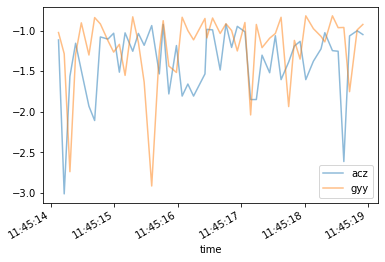

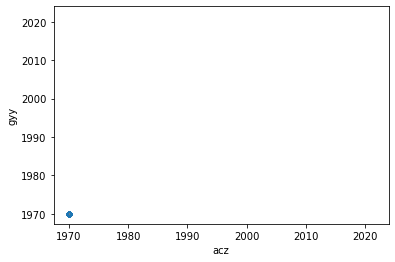

In [7]:
from scipy.signal import find_peaks

start_date = pd.to_datetime('2021-05-30 11:45:14')
end_date = pd.to_datetime('2021-05-30 11:45:19')
df_filtered = df_raw.loc[(df_raw['time'] > start_date) & (df_raw['time'] < end_date)]

df_filtered.index = df_filtered['time']
# df_filtered = df_raw.copy()
# df_raw = df_raw.between_time('18:52:30', '18:52:40')
# df_raw = df_raw[df_raw['time'] > '2021-06-09 18:52:30' & df_raw['time'] < '2021-06-09 18:52:40']

# df_filtered['acy'] = np.log10(df_filtered['acy'])
# df_filtered['acx'] = np.log10(df_filtered['acx'])
df_filtered['acz'] = np.log10(df_filtered['acz'])
df_filtered['gyy'] = np.log10(df_filtered['gyy']) - 2
df_filtered.plot.line('time', ['acz', 'gyy'], alpha=0.5)
df_filtered.plot.scatter(x='acz', y='gyy')
# df_filtered['time_delta'] = df_filtered['time']  / np.timedelta64(1,'D')

x = df_filtered.iloc[:,6]
peaks, _ = find_peaks(x, height=0, distance=150)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

# plt.plot(peaks, x[peaks], "x")
# plt.show()

## Experimenting 'windowing'

> No working nor conclusive work yet.

In [ ]:
# y_rolling_avg = df_result['sac'].rolling(window=5).mean()
# #plt.plot(x, y)
# #plt.figure(10,5)
# #plt.plot(x, y_rolling_avg, color='red')
# sns.lineplot(y = 'sac', x = 'sac', data = y_rolling_avg)
# plt.show()

Per window of interest, we'll collect
* Accelerometer agg (Mean, Max & Min)
* Window start (Min) and End date (Max)
* Binarized image of the Time Series segment (plotted). For Vision analysis and modeling.

### Get images per window and stack against what we have up to this point

In [ ]:
# TODO: run & `binarize` this. per segment into data.

# for i in range(0,60):
#     current_second = df_raw_micro[(df_raw_micro['second'] == i)]
#     plt.figure(figsize=(10,3))
#     # sns.lineplot(y = 'acx', x = 'time', data = current_second)
#     # sns.lineplot(y = 'acy', x = 'time', data = current_second)
#     # sns.lineplot(y = 'acz', x = 'time', data = current_second)
#     sns.lineplot(y = 'sac', x = 'time', data = current_second)
#     # plt.legend(['x-axis', 'y-axis', 'z-axis'])
#     # plt.ylabel(i)
#     # plt.title(i, fontsize = 15)
#     plt.show()

In [ ]:
# TODO: optimize this block.

_HALF_SEC = 5 # for a 10hz capture

agg_array = np.array([0,0,0,0,0,0,0,0])
for i in range(0,len(df_raw), _HALF_SEC):
    window_measure = df_raw.iloc[i:i+4,7]
    window_measure_gy = df_raw.iloc[i:i+4,8]
    window_time = df_raw.iloc[i:i+4,6]
    to_add = np.array(
        [window_measure.mean(),
         window_measure.max(),
         window_measure.min(),
         window_measure_gy.mean(),
         window_measure_gy.max(),
         window_measure_gy.min(),
         window_time.min(),
         window_time.max()])
    agg_array = np.vstack((agg_array, to_add))
agg_array = np.delete(agg_array, 0, axis=0)

In [ ]:
df_raw_agg = pd.DataFrame(agg_array, columns=['sac_mean', 'sac_max', 'sac_min', 'sgy_mean', 'sgy_max', 'sgy_min', 'first_event', 'last_event'])
df_raw_agg['time_delta'] = (df_raw_agg['first_event'] - df_raw_agg['first_event'].min())  / np.timedelta64(1,'D')
df_raw_agg[['sac_mean', 'sac_max', 'sac_min']] = df_raw_agg[['sac_mean', 'sac_max', 'sac_min']].astype(float, errors = 'raise')
df_raw_agg[['sgy_mean', 'sgy_max', 'sgy_min']] = df_raw_agg[['sgy_mean', 'sgy_max', 'sgy_min']].astype(float, errors = 'raise')
df_raw_agg.drop(["first_event", "last_event"], axis=1, inplace=True)
df_raw_agg.info()

In [ ]:
# reduce size for testing
from scipy.signal import find_peaks

df_raw_agg.plot.scatter(x="sac_max", y="sgy_max", alpha=0.5)#, subplots=True)
df_raw_agg.plot.scatter(x="sac_max", y="sgy_min", alpha=0.5)#, subplots=True)
df_raw_agg.plot.scatter(x="sgy_max", y="sgy_min", alpha=0.5)#, subplots=True)
plt.show()
# df_raw_agg = df_raw_agg.iloc[200:3000]
# df_raw_agg.head()
x = df_raw_agg.iloc[:,1]
peaks, _ = find_peaks(x, height=0, distance=10)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

plt.plot(peaks, x[peaks], "x")
plt.show()

### 1. Clustering using Tslearn

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

N_CLUSTERS = 4
TIME_COL = 6
MEASURES = 3
for i in range(MEASURES):
    
    X_train = df_raw_agg.iloc[:, [TIME_COL,i,i+MEASURES]].to_numpy()

    km = TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                           metric="dtw",
                           verbose=False,
                           random_state=42)
    labels = km.fit_predict(X_train)

    sz = X_train.shape[1]

    plt.figure()
    for yi in range(N_CLUSTERS):
        plt.subplot(1, N_CLUSTERS, yi + 1)
        for xx in X_train[labels == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(0, 0.19)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("DTW $k$-means {}".format(i))
        
        
    plt.tight_layout()
    plt.show()

    df_raw_agg['label_{}'.format(i)] = labels

    sns.set_style("whitegrid")
    plt.figure(figsize = (7, 3))
    sns.countplot(x = 'label_{}'.format(i), data = df_raw_agg)
    plt.title('Number of samples by activity')
    plt.show()